In [24]:
import cv2
import numpy as np
from typing import Optional, List, Tuple, Any
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torchvision as tv

def make_grid_image(
    img_size: int,
    n_squares: int,
    n_crosses: int,
    grid_dim: int,
    seed: Optional[int] = None,
    noise_std: Optional[float] = None,
) -> np.ndarray:
    """
    Create a square image of size (img_size, img_size, 3) with a grid of grid_dim x grid_dim.
    Randomly choose n_squares cells to fill blue. In each chosen cell, draw a green circle
    at the center, except for n_crosses of those, which get a green cross instead.
    Background is black.

    Optionally adds Gaussian noise with standard deviation noise_std.

    Args:
        img_size: Output image side length in pixels (image is always square).
        n_squares: Number of blue squares (filled cells) to place.
        n_crosses: Among the blue squares, how many should have a green cross (the rest get a green circle).
        grid_dim: Number of cells per side (grid_dim x grid_dim total cells).
        seed: Optional random seed for reproducibility.
        noise_std: Standard deviation of Gaussian noise. If None or 0, no noise.

    Returns:
        np.ndarray: The generated BGR image.
    """
    if n_squares < 0 or n_crosses < 0:
        raise ValueError("n_squares and n_crosses must be non-negative.")
    total_cells = grid_dim * grid_dim
    if n_squares > total_cells:
        raise ValueError(f"n_squares ({n_squares}) cannot exceed total grid cells ({total_cells}).")
    if n_crosses > n_squares:
        raise ValueError("n_crosses cannot exceed n_squares.")

    rng = np.random.default_rng(seed)

    BLUE = (255, 0, 0)
    GREEN = (0, 255, 0)
    BG = (0, 0, 0)  # black background

    img = np.full((img_size, img_size, 3), BG, dtype=np.uint8)
    step = img_size / grid_dim

    chosen = rng.choice(total_cells, size=n_squares, replace=False) if n_squares > 0 else np.array([], dtype=int)
    cross_idx = set(rng.choice(chosen, size=n_crosses, replace=False).tolist()) if n_crosses > 0 else set()

    def cell_bounds(r: int, c: int):
        x0 = int(round(c * step))
        x1 = int(round((c + 1) * step))
        y0 = int(round(r * step))
        y1 = int(round((r + 1) * step))
        return x0, y0, x1, y1

    for cell in chosen:
        r, c = divmod(int(cell), grid_dim)
        x0, y0, x1, y1 = cell_bounds(r, c)
        cv2.rectangle(img, (x0, y0), (x1 - 1, y1 - 1), BLUE, thickness=-1)

        cx = (x0 + x1) // 2
        cy = (y0 + y1) // 2
        w = x1 - x0
        h = y1 - y0
        m = min(w, h)

        if cell in cross_idx:
            half_len = int(0.3 * m)
            thick = max(1, int(0.08 * m))
            cv2.line(img, (cx - half_len, cy), (cx + half_len, cy), GREEN, thickness=thick)
            cv2.line(img, (cx, cy - half_len), (cx, cy + half_len), GREEN, thickness=thick)
        else:
            radius = max(1, int(0.3 * m))
            cv2.circle(img, (cx, cy), radius, GREEN, thickness=-1)

    # Add noise if requested
    if noise_std and noise_std > 0:
        noise = rng.normal(0, noise_std, img.shape).astype(np.float32)
        noisy_img = img.astype(np.float32) + noise
        img = np.clip(noisy_img, 0, 255).astype(np.uint8)

    return img
def extract_grid_patches(img: np.ndarray, grid_dim: int) -> Tuple[List[Tuple[int, int]], List[np.ndarray]]:
    """
    Partition an image into a grid of grid_dim x grid_dim and return
    (top-left_y, top-left_x) coordinates and the corresponding patches.

    Notes:
    - Works for grayscale (H, W) or color (H, W, C) images.
    - Uses rounded floating boundaries so all patches exactly cover the image.
      Patch sizes may differ by at most 1 px due to rounding.
    - Coordinates are (y, x) for the top-left corner of each patch.

    Args:
        img: Input image as a numpy array.
        grid_dim: Number of cells per side.

    Returns:
        coords: List of (y, x) integer coordinates for each patch's top-left corner.
        patches: List of numpy arrays (each patch).
    """
    if grid_dim <= 0:
        raise ValueError("grid_dim must be a positive integer.")

    H, W = img.shape[:2]
    step_y = H / grid_dim
    step_x = W / grid_dim

    coords: List[Tuple[int, int]] = []
    patches: List[np.ndarray] = []

    # helper to compute integer bounds via rounded float gridlines
    def bounds(i: int, j: int):
        y0 = int(round(i * step_y))
        y1 = int(round((i + 1) * step_y))
        x0 = int(round(j * step_x))
        x1 = int(round((j + 1) * step_x))
        return y0, y1, x0, x1

    for i in range(grid_dim):
        for j in range(grid_dim):
            y0, y1, x0, x1 = bounds(i, j)
            patch = img[y0:y1, x0:x1, ...] if img.ndim == 3 else img[y0:y1, x0:x1]
            coords.append((y0, x0))
            patches.append(patch)

    return coords, patches

def _get_backbone(model_name: str = "resnet50", weights: str = "DEFAULT") -> Tuple[nn.Module, tv.transforms.Compose, int]:
    """
    Return a backbone with its preprocessing transform and output feature dim.
    Replaces the classifier head with Identity so forward() returns penultimate features.
    """
    name = model_name.lower()

    if name == "resnet50":
        Weights = tv.models.ResNet50_Weights
        m = tv.models.resnet50(weights=getattr(Weights, weights))
        m.fc = nn.Identity()
        feat_dim = 2048
        preprocess = Weights.DEFAULT.transforms()
    elif name == "resnet18":
        Weights = tv.models.ResNet18_Weights
        m = tv.models.resnet18(weights=getattr(Weights, weights))
        m.fc = nn.Identity()
        feat_dim = 512
        preprocess = Weights.DEFAULT.transforms()
    elif name == "efficientnet_b0":
        Weights = tv.models.EfficientNet_B0_Weights
        m = tv.models.efficientnet_b0(weights=getattr(Weights, weights))
        m.classifier = nn.Identity()
        feat_dim = 1280
        preprocess = Weights.DEFAULT.transforms()
    elif name == "convnext_tiny":
        Weights = tv.models.ConvNeXt_Tiny_Weights
        m = tv.models.convnext_tiny(weights=getattr(Weights, weights))
        # ConvNeXt classifier = LayerNorm2d -> Flatten -> Linear; keep Flatten input
        m.classifier = nn.Sequential(*list(m.classifier.children())[:-1], nn.Identity())
        feat_dim = m.classifier[0].normalized_shape[0]  # channels before flatten (should be 768), then flattened by forward
        preprocess = Weights.DEFAULT.transforms()
    elif name == "vit_b_16":
        Weights = tv.models.ViT_B_16_Weights
        m = tv.models.vit_b_16(weights=getattr(Weights, weights))
        m.heads = nn.Identity()
        feat_dim = 768
        preprocess = Weights.DEFAULT.transforms()
    else:
        raise ValueError(f"Unsupported model_name='{model_name}'. Try one of: resnet50, resnet18, efficientnet_b0, convnext_tiny, vit_b_16.")

    m.eval()
    return m, preprocess, feat_dim


def imagenet_features_from_patches(
    patches: List[np.ndarray],
    model_name: str = "resnet50",
    batch_size: int = 64,
    device: Optional[str] = None,
    bgr_input: bool = True,   # set False if your patches are already RGB
) -> np.ndarray:
    """
    Compute ImageNet features for a list of patches (NumPy arrays).
    - Patches can be HxW (grayscale) or HxWx3 (color). If grayscale, it will be stacked to 3 channels.
    - Arrays are assumed BGR if coming from OpenCV; set bgr_input=False if already RGB.
    - Returns a float32 array of shape (N, D) with D depending on the backbone.

    Args:
        patches: list of np.ndarray images.
        model_name: backbone name ('resnet50','resnet18','efficientnet_b0','convnext_tiny','vit_b_16').
        batch_size: inference batch size.
        device: 'cuda', 'cpu', or None to auto-select.
        bgr_input: True if patches are BGR (OpenCV). Converted to RGB internally.

    Returns:
        features: np.ndarray [N, D], dtype float32
    """
    if len(patches) == 0:
        return np.empty((0, 0), dtype=np.float32)

    dev = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model, preprocess, feat_dim = _get_backbone(model_name)
    model.to(dev)

    # Build a simple generator that yields preprocessed tensors
    def _to_tensor_list(batch_imgs: List[np.ndarray]) -> torch.Tensor:
        tensor_list = []
        for im in batch_imgs:
            if im.ndim == 2:  # grayscale -> 3ch
                im = np.stack([im, im, im], axis=-1)
            if bgr_input:
                im = im[..., ::-1]  # BGR -> RGB
            # preprocess expects PIL or tensor in [0,1] RGB; convert to PIL via torchvision
            pil = tv.transforms.functional.to_pil_image(im)
            t = preprocess(pil)   # [3,H,W], normalized
            print("before:", im.mean(), im.std(), "after:", t.mean().item(), t.std().item())
            tensor_list.append(t)
        return torch.stack(tensor_list, dim=0)

    feats = np.zeros((len(patches), feat_dim), dtype=np.float32)

    model_was_training = model.training
    model.eval()
    with torch.no_grad():
        for start in range(0, len(patches), batch_size):
            end = min(start + batch_size, len(patches))
            batch = _to_tensor_list(patches[start:end]).to(dev, non_blocking=True)
            out = model(batch)
            # Some backbones may return [N, C, 1, 1]; flatten safely
            if out.ndim > 2:
                out = torch.flatten(out, 1)
            feats[start:end] = out.detach().float().cpu().numpy()

    if model_was_training:
        model.train()
    return feats


_GLOBAL_PROJ = None  # cached projection matrix

def synthetic_features_from_patches(
    patches: list[np.ndarray],
    embed_dim: int = 2048,
    seed: int = 42,
    normalize: bool = True,
) -> np.ndarray:
    """
    Create synthetic features by flattening each patch and projecting
    through a fixed random matrix shared across all slides.
    """
    if len(patches) == 0:
        return np.empty((0, embed_dim), dtype=np.float32)

    h, w, c = patches[0].shape
    flat_dim = h * w * c

    # initialize global projection once
    global _GLOBAL_PROJ
    if _GLOBAL_PROJ is None:
        rng = np.random.default_rng(seed)
        _GLOBAL_PROJ = rng.standard_normal((flat_dim, embed_dim)).astype(np.float32)
        _GLOBAL_PROJ /= np.sqrt(flat_dim)

    # flatten all patches → [N, HWC]
    flat = np.stack([p.astype(np.float32).reshape(-1) / 255.0 for p in patches])
    if normalize:
        flat -= flat.mean(axis=1, keepdims=True)
        flat /= flat.std(axis=1, keepdims=True) + 1e-6

    feats = flat @ _GLOBAL_PROJ
    return feats

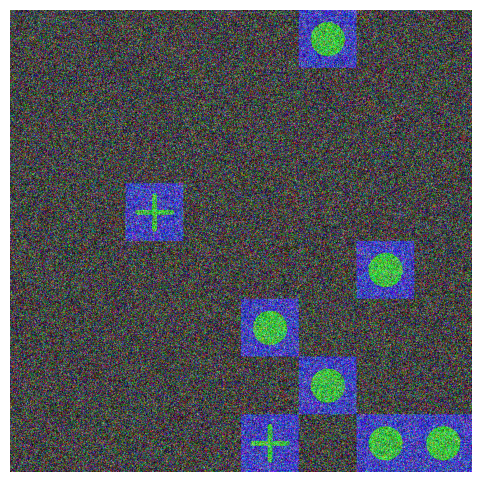

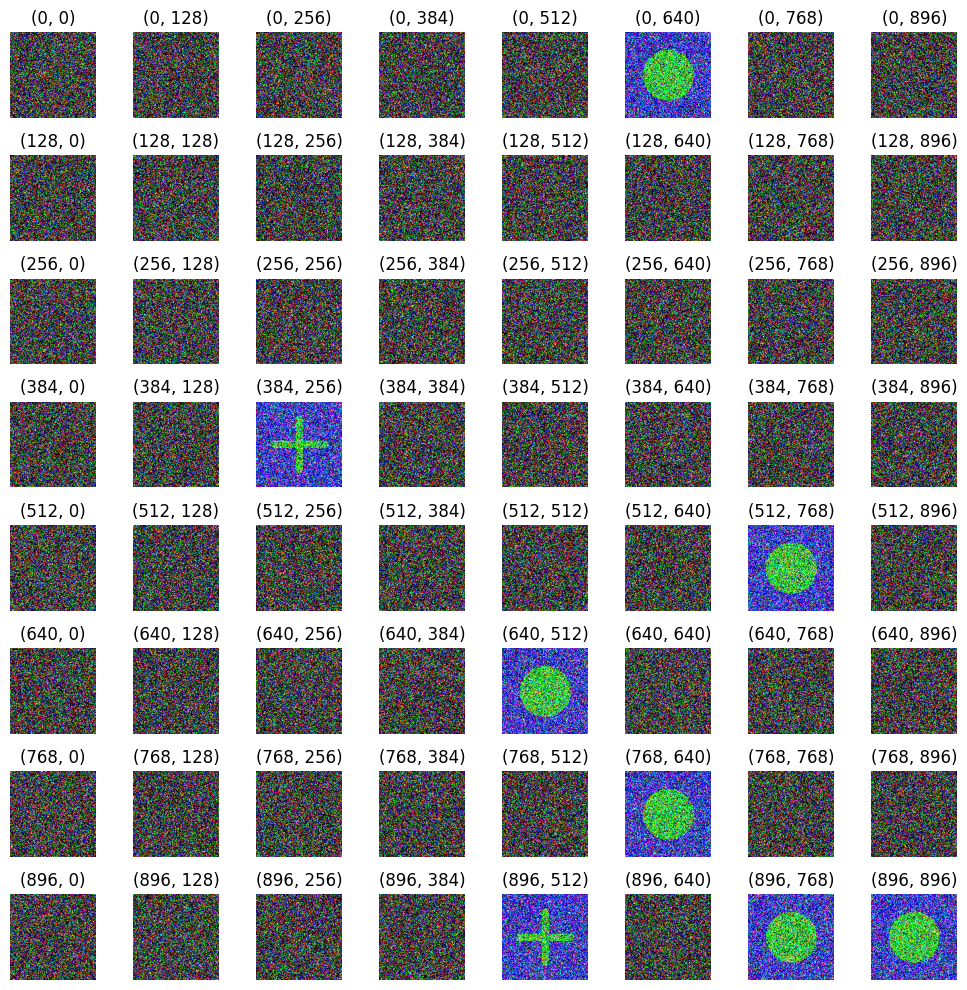

In [2]:
# Example with black background and no grid lines
example_img_black_nogrid = make_grid_image(
    img_size=1024,
    n_squares=8,
    n_crosses=2,
    grid_dim=8,
    seed=42,
    noise_std=200
)

example_img_black_nogrid_rgb = cv2.cvtColor(example_img_black_nogrid, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(example_img_black_nogrid_rgb)
plt.axis("off")
plt.show()

# Extract patches and visualize each with its top-left coordinates
grid_dim = 8
coords, patches = extract_grid_patches(example_img_black_nogrid, grid_dim=grid_dim)

fig, axes = plt.subplots(grid_dim, grid_dim, figsize=(10,10))
idx = 0
for i in range(grid_dim):
    for j in range(grid_dim):
        ax = axes[i, j]
        ax.imshow(cv2.cvtColor(patches[idx], cv2.COLOR_BGR2RGB))
        ax.set_title(f"{coords[idx]}")
        ax.axis("off")
        idx += 1

plt.tight_layout()
plt.show()

In [12]:
features = imagenet_features_from_patches(patches=patches,
                                          model_name="resnet50",
                                          batch_size=64,
                                          bgr_input=True)


In [25]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from pathlib import Path
from PIL import Image
import torch
import random

# ----------------------------
# Configuration
# ----------------------------
ROOT = Path("../data/toy_set_random_proj").resolve()
SLIDES_DIR = ROOT / "slides"
PARQUET_DIR = ROOT / "parquet"
LABELS_DIR = PARQUET_DIR / "labels"
SPLITS_DIR = PARQUET_DIR / "splits"
LOWRES_DIR = PARQUET_DIR / "lowres"

N_SLIDES = 12
IMG_SIZE = 1024
LOWRES_FACTOR = 4
LOWRES_SIZE = IMG_SIZE // LOWRES_FACTOR
GRID_DIM = 8
N_SQUARES = 8
NOISE_STD = 0
FEATURE_SET = "resnet50_v1"
MODEL_NAME = "resnet50"
BATCH_SIZE = 64
BGR_INPUT = True

TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.70, 0.15, 0.15
RNG_SEED = 2025


# ----------------------------
# assume helpers exist:
# - make_grid_image(...)
# - extract_grid_patches(image, grid_dim)
# - imagenet_features_from_patches(patches, ...)
# ----------------------------


# ----------------------------
# Utilities
# ----------------------------
def stratified_splits(slide_ids, labels, train=0.7, val=0.15, test=0.15, seed=RNG_SEED):
    rng = random.Random(seed)
    df = pd.DataFrame({"slide_id": slide_ids, "label": labels})
    rows = []
    for lbl, group in df.groupby("label"):
        g_ids = group["slide_id"].tolist()
        rng.shuffle(g_ids)
        n = len(g_ids)
        n_train = int(round(n * train))
        n_val = int(round(n * val))
        n_test = n - n_train - n_val
        for sid in g_ids[:n_train]:
            rows.append((sid, "train"))
        for sid in g_ids[n_train:n_train+n_val]:
            rows.append((sid, "val"))
        for sid in g_ids[n_train+n_val:]:
            rows.append((sid, "test"))
    return pd.DataFrame(rows, columns=["slide_id", "split"])


def ensure_dirs():
    for d in [SLIDES_DIR, PARQUET_DIR, LABELS_DIR, SPLITS_DIR, LOWRES_DIR]:
        d.mkdir(parents=True, exist_ok=True)


def save_tiles_parquet(rows: list):
    df = pd.DataFrame(rows).sort_values(["slide_id", "tile_id"]).reset_index(drop=True)
    pq.write_table(pa.Table.from_pandas(df), PARQUET_DIR / "tiles.parquet")


def save_features_parquet(rows: list):
    df = pd.DataFrame(rows).sort_values(["slide_id", "tile_id"]).reset_index(drop=True)
    pq.write_table(pa.Table.from_pandas(df), PARQUET_DIR / "features.parquet")


def save_labels_parquet(slide_ids, labels):
    df = pd.DataFrame({"slide_id": slide_ids, "label": labels}).sort_values("slide_id").reset_index(drop=True)
    pq.write_table(pa.Table.from_pandas(df), LABELS_DIR / "slide_labels.parquet")


def save_lowres_parquet(rows: list[dict]):
    df = pd.DataFrame(rows).sort_values("slide_id").reset_index(drop=True)
    out_path = LOWRES_DIR / "thumbnails.parquet"
    pq.write_table(pa.Table.from_pandas(df), out_path)
    return out_path


# ----------------------------
# Main synthetic dataset builder
# ----------------------------
def main():
    random.seed(RNG_SEED)
    np.random.seed(RNG_SEED)
    ensure_dirs()

    slide_ids = [f"slide_{i:04d}" for i in range(N_SLIDES)]
    labels = np.array([0]*(N_SLIDES//2) + [1]*(N_SLIDES//2), dtype=int)
    np.random.shuffle(labels)

    all_tile_rows = []
    all_feature_rows = []
    lowres_rows = []

    for idx, (slide_id, label) in enumerate(zip(slide_ids, labels.tolist())):
        n_crosses = int(np.random.choice([1, 2, 3])) if label == 1 else 0
        img_seed = RNG_SEED + idx

        # --- make synthetic slide ---
        img = make_grid_image(
            img_size=IMG_SIZE,
            n_squares=N_SQUARES,
            n_crosses=n_crosses,
            grid_dim=GRID_DIM,
            seed=img_seed,
            noise_std=NOISE_STD,
        )

        # --- thumbnail ---
        slide_dir = SLIDES_DIR / slide_id
        slide_dir.mkdir(parents=True, exist_ok=True)
        thumb_path = slide_dir / "thumbnail.jpg"
        Image.fromarray(img).resize((LOWRES_SIZE, LOWRES_SIZE), Image.BILINEAR).save(thumb_path, "JPEG", quality=95)
        lowres_rows.append({
            "slide_id": slide_id,
            "lowres_uri": str(thumb_path.relative_to(ROOT)),
        })

        # --- extract tiles ---
        coords, patches = extract_grid_patches(img, grid_dim=GRID_DIM)
        tile_dir = slide_dir / "tiles"
        tile_dir.mkdir(parents=True, exist_ok=True)

        # --- feature folder per slide, with subfolder per feature_set ---
        feat_root = slide_dir / "features"
        feat_dir = feat_root / f"feature_set={FEATURE_SET}"
        feat_dir.mkdir(parents=True, exist_ok=True)

        # feats = imagenet_features_from_patches(
        #     patches=patches,
        #     model_name=MODEL_NAME,
        #     batch_size=BATCH_SIZE,
        #     bgr_input=BGR_INPUT,
        # )

        feats = synthetic_features_from_patches(
            patches=patches,
            embed_dim=2048,
            seed=RNG_SEED
        )

        print(feats.shape)
        feats = np.asarray(feats)

        for t_idx, (xy, patch, vec) in enumerate(zip(coords, patches, feats)):
            tile_id = f"{t_idx:06d}"
            x, y = map(int, xy)

            # save tile image
            tile_path = tile_dir / f"tile_{tile_id}.jpg"
            Image.fromarray(patch).save(tile_path, format="JPEG", quality=95)

            # save feature as torch tensor (.pt)
            feat_path = feat_dir / f"tile_{tile_id}.npy"
            np.save(feat_path, vec.astype(np.float32), allow_pickle=False)

            # record metadata
            all_tile_rows.append({
                "slide_id": slide_id,
                "tile_id": tile_id,
                "x": x,
                "y": y,
                "level": 0,
                "mpp": 1.0,
                "patch_uri": str(tile_path.relative_to(ROOT)),
            })

            all_feature_rows.append({
                "slide_id": slide_id,
                "tile_id": tile_id,
                "x": x,
                "y": y,
                "feature_set": FEATURE_SET,
                "feature_uri": str(feat_path.relative_to(ROOT)),  # inside slides/slide_xxxx/features/feature_set=...
            })

    # --- write parquets ---
    save_tiles_parquet(all_tile_rows)
    save_features_parquet(all_feature_rows)
    save_labels_parquet(slide_ids, labels.tolist())

    # splits parquet
    splits_df = stratified_splits(slide_ids, labels, TRAIN_RATIO, VAL_RATIO, TEST_RATIO, seed=RNG_SEED)
    pq.write_table(pa.Table.from_pandas(splits_df.sort_values("slide_id").reset_index(drop=True)),
                   SPLITS_DIR / "fold1.parquet")

    # lowres parquet
    lowres_parquet_path = save_lowres_parquet(lowres_rows)

    # summary
    print(f"Dataset root: {ROOT}")
    print("Wrote:")
    print(f"  - tiles -> {PARQUET_DIR/'tiles.parquet'}")
    print(f"  - features -> {PARQUET_DIR/'features.parquet'}")
    print(f"  - labels -> {LABELS_DIR/'slide_labels.parquet'}")
    print(f"  - splits -> {SPLITS_DIR/'fold1.parquet'}")
    print(f"  - lowres -> {lowres_parquet_path}")
    print("Example slide dir:", SLIDES_DIR / slide_ids[0])
    print("Example feature dir:", SLIDES_DIR / slide_ids[0] / "features" / f"feature_set={FEATURE_SET}")


main()



(64, 2048)
(64, 2048)
(64, 2048)
(64, 2048)
(64, 2048)
(64, 2048)
(64, 2048)
(64, 2048)
(64, 2048)
(64, 2048)
(64, 2048)
(64, 2048)
Dataset root: /home/alpaca/Documents/van/wsi_sampling/data/toy_set_random_proj
Wrote:
  - tiles -> /home/alpaca/Documents/van/wsi_sampling/data/toy_set_random_proj/parquet/tiles.parquet
  - features -> /home/alpaca/Documents/van/wsi_sampling/data/toy_set_random_proj/parquet/features.parquet
  - labels -> /home/alpaca/Documents/van/wsi_sampling/data/toy_set_random_proj/parquet/labels/slide_labels.parquet
  - splits -> /home/alpaca/Documents/van/wsi_sampling/data/toy_set_random_proj/parquet/splits/fold1.parquet
  - lowres -> /home/alpaca/Documents/van/wsi_sampling/data/toy_set_random_proj/parquet/lowres/thumbnails.parquet
Example slide dir: /home/alpaca/Documents/van/wsi_sampling/data/toy_set_random_proj/slides/slide_0000
Example feature dir: /home/alpaca/Documents/van/wsi_sampling/data/toy_set_random_proj/slides/slide_0000/features/feature_set=resnet50_v1


In [28]:
from torch.utils.data import Dataset

class BaseDataset(Dataset):
    """
    Option A dataset loader:
      - Features: Parquet dataset partitioned by feature_set and slide_id
      - Tiles index: tiles.parquet (static)
      - Labels: slide_labels.parquet
      - Splits: splits/fold1.parquet (slide-level)
    Modes:
      - features_only=True  -> returns (feature, label, meta)
      - features_only=False -> returns (image_tensor, feature, label, meta)
    Notes:
      - image decoding uses PIL; transform can be any torchvision-style callable
      - features returned as float32 torch tensors
    """

    def __init__(
        self,
        root: str | Path,
        feature_set: str,
        split: str,
        features_only: bool = True,
        transform: Optional[Any] = None,
        tiles_parquet_name: str = "tiles.parquet",
        labels_parquet_rel: str = "labels/slide_labels.parquet",
        splits_parquet_rel: str = "splits/fold1.parquet",
        image_key: str = "patch_uri",
        image_mode: str = "RGB",
    ):
        super().__init__()
        self.root = Path(root).resolve()
        self.feature_set = feature_set
        self.split = split
        self.features_only = features_only
        self.transform = transform
        self.image_key = image_key
        self.image_mode = image_mode

        parquet_dir = self.root / "parquet"
        features_dir = parquet_dir / "features"
        tiles_parquet = parquet_dir / tiles_parquet_name
        labels_parquet = parquet_dir / labels_parquet_rel
        splits_parquet = parquet_dir / splits_parquet_rel

        # --- Load split (slide-level) ---
        splits_df = pd.read_parquet(splits_parquet)
        if "split" not in splits_df.columns or "slide_id" not in splits_df.columns:
            raise ValueError("splits parquet must have columns: slide_id, split")
        splits_df = splits_df[splits_df["split"] == self.split][["slide_id"]].drop_duplicates()

        # --- Load labels ---
        labels_df = pd.read_parquet(labels_parquet)
        if "slide_id" not in labels_df.columns or "label" not in labels_df.columns:
            raise ValueError("labels parquet must have columns: slide_id, label")

        # --- Load features with Arrow filters (only chosen feature_set + chosen slides) ---
        feat_ds = ds.dataset(features_dir, format="parquet", partitioning="hive")

        # Build filter: feature_set == X AND slide_id IN {split slides}
        slide_ids_in_split = pa.array(splits_df["slide_id"].unique().tolist(), type=pa.string())
        filt = (ds.field("feature_set") == pa.scalar(self.feature_set)) & (ds.field("slide_id").isin(slide_ids_in_split))

        # We only need a few columns; include x,y for convenience
        feat_tbl = feat_ds.to_table(filter=filt, columns=["slide_id", "tile_id", "x", "y", "feature_set", "feature"])
        feat_df = feat_tbl.to_pandas(types_mapper=pd.ArrowDtype)

        if feat_df.empty:
            raise RuntimeError(f"No feature rows found for feature_set='{self.feature_set}' and split='{self.split}'.")

        # Convert Arrow fixed-size list "feature" to numpy arrays cleanly
        # Depending on versions, this may already be ndarray-like; ensure np.array of shape (D,)
        feat_df["feature"] = feat_df["feature"].apply(lambda v: np.asarray(v, dtype=np.float32))

        # --- Join labels (slide-level) ---
        feat_df = feat_df.merge(labels_df, on="slide_id", how="left")
        if feat_df["label"].isna().any():
            missing = feat_df[feat_df["label"].isna()]["slide_id"].unique().tolist()
            raise RuntimeError(f"Missing labels for slides: {missing[:10]} (showing up to 10)")

        # --- If pixels+features: join with tiles index to get patch_uri ---
        if not self.features_only:
            tiles_df = pd.read_parquet(tiles_parquet)[["slide_id", "tile_id", self.image_key]]
            if tiles_df.empty:
                raise RuntimeError("tiles.parquet is empty or missing required columns.")
            self.df = feat_df.merge(tiles_df, on=["slide_id", "tile_id"], how="left")
            if self.df[self.image_key].isna().any():
                bad = self.df[self.df[self.image_key].isna()][["slide_id", "tile_id"]].head(10)
                raise RuntimeError(f"Some (slide_id, tile_id) missing in tiles index, e.g.\n{bad}")
        else:
            self.df = feat_df

        # Keep a deterministic order (optional)
        self.df = self.df.sort_values(["slide_id", "tile_id"]).reset_index(drop=True)

        # Cache for speed
        self._root_str = str(self.root)

    def __len__(self) -> int:
        return len(self.df)

    def _load_image(self, rel_path: str) -> Image.Image:
        # Images are stored with paths relative to dataset root (as saved in tiles.parquet)
        img_path = Path(self._root_str) / rel_path
        with Image.open(img_path) as im:
            return im.convert(self.image_mode)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]

        # Feature vector
        feat = row["feature"]
        if not isinstance(feat, np.ndarray):
            feat = np.asarray(feat, dtype=np.float32)
        feat_t = torch.from_numpy(feat.astype(np.float32, copy=False))

        # Label (slide-level)
        label = int(row["label"])
        label_t = torch.tensor(label, dtype=torch.long)

        meta = {
            "slide_id": row["slide_id"],
            "tile_id": row["tile_id"],
            "x": int(row["x"]),
            "y": int(row["y"]),
            "feature_set": row["feature_set"],
        }

        if self.features_only:
            return feat_t, label_t, meta

        # Pixels + features path
        rel = row[self.image_key]
        img = self._load_image(rel)
        if self.transform is not None:
            img = self.transform(img)
        else:
            # default: convert to tensor in [0,1], CHW
            img = torch.from_numpy(np.array(img)).permute(2, 0, 1).float() / 255.0

        return img, feat_t, label_t, meta

In [20]:
from torch.utils.data import DataLoader

ROOT = "../data/toy_set"
FEATURE_SET = "resnet50_v1"

# Features-only training set
train_feat_ds = BaseDataset(
    root=ROOT,
    feature_set=FEATURE_SET,
    split="train",
    features_only=True,      # fast MIL mode: no image decoding
    transform=None
)
print("features-only train size:", len(train_feat_ds))
feat0, lab0, meta0 = train_feat_ds[0]
print("feature shape:", tuple(feat0.shape), "label:", lab0.item(), "meta:", meta0)

# Pixels + features (e.g., for sanity checks or hybrid models)
train_pixfeat_ds = BaseDataset(
    root=ROOT,
    feature_set=FEATURE_SET,
    split="train",
    features_only=False,     # decode images too
    transform=None           # or any torchvision transform
)
print("pixels+features train size:", len(train_pixfeat_ds))
img0, feat0b, lab0b, meta0b = train_pixfeat_ds[0]
print("image tensor:", tuple(img0.shape), "feature:", tuple(feat0b.shape), "label:", lab0b.item())

# Dataloaders
loader = DataLoader(train_feat_ds, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
for batch in loader:
    feats, labels, metas = batch
    print("batch feats:", feats.shape, "labels:", labels.shape)
    break

NameError: name 'BaseDataset' is not defined

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Low-res batch: torch.Size([4, 3, 256, 256])
Coords padded: torch.Size([4, 64, 2])
Coord mask: torch.Size([4, 64])
Labels: tensor([1, 1, 1, 0])
Views: [<src.data.datasets.SlideView object at 0x7f78d461a4d0>, <src.data.datasets.SlideView object at 0x7f78d46186a0>, <src.data.datasets.SlideView object at 0x7f78d461b7f0>, <src.data.datasets.SlideView object at 0x7f78d461a8f0>]
Fetched patches: torch.Size([5, 3, 128, 128])
Fetched patches: torch.Size([5, 3, 128, 128])
Fetched patches: torch.Size([5, 3, 128, 128])
Fetched patches: torch.Size([5, 3, 128, 128])


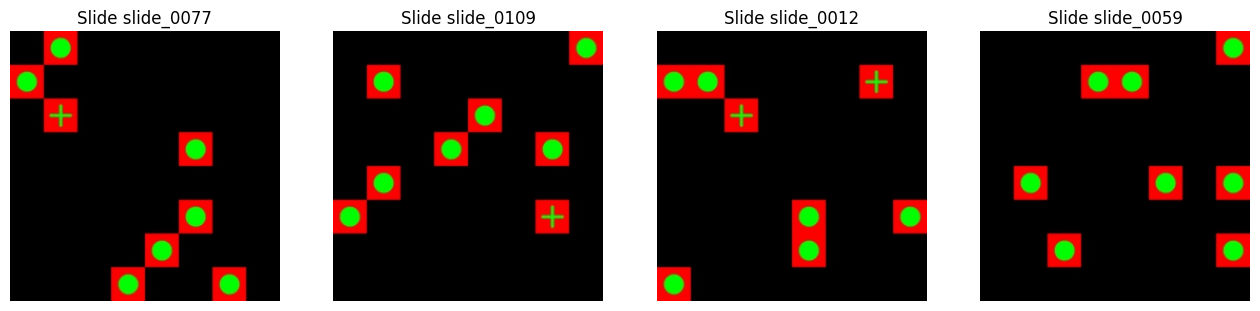

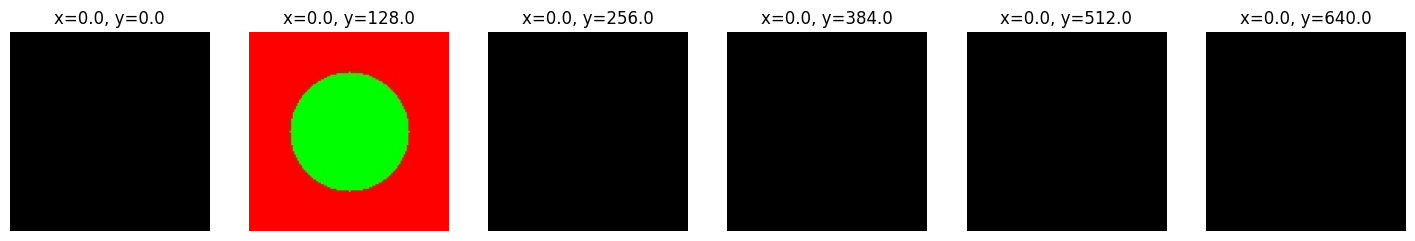

In [21]:
%load_ext autoreload
%autoreload 2

from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import sys 
sys.path.append("..")  # to import from parent dir
from src.data.datasets import SlideDataset, slide_collate

ROOT = "../data/toy_set"

# Example transforms
lowres_tfm = transforms.Compose([
    transforms.Resize((256, 256)),  # thumbnails to fixed size
    transforms.ToTensor(),
])
patch_tfm = transforms.ToTensor()  # applied when fetching full patches

# Dataset (no sampler inside)
ds = SlideDataset(
    root=ROOT,
    split="train",
    lowres_transform=lowres_tfm,
    patch_transform=patch_tfm,
)

# DataLoader uses slide_collate
dl = DataLoader(
    ds,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=slide_collate,
)


batch = next(iter(dl))
print("Low-res batch:", batch["lowres"].shape)       # [B,C,H0,W0]
print("Coords padded:", batch["coords_pad"].shape)   # [B,Nmax,2]
print("Coord mask:", batch["coord_mask"].shape)      # [B,Nmax]
print("Labels:", batch["labels"])
print("Views:", batch["views"])                      # list of SlideView handles

# Example: simulate sampler picking 5 patches from each slide
for view, coords in zip(batch["views"], batch["coords_pad"]):
    K = 5
    idxs = list(range(min(K, coords.shape[0])))  # pretend sampler picked first K
    patches = view.fetch(idxs)                   # [K,C,H,W]
    print("Fetched patches:", patches.shape)

# Show thumbnails (lowres) for the batch
B = batch["lowres"].shape[0]
fig, axs = plt.subplots(1, B, figsize=(4*B, 4))
for i in range(B):
    ax = axs[i] if B > 1 else axs
    thumb = batch["lowres"][i]             # [C,H0,W0]
    ax.imshow(TF.to_pil_image(thumb))      # convert to PIL for display
    ax.set_title(f"Slide {batch['slide_ids'][i]}")
    ax.axis("off")
plt.show()

# Now pick a slide, fetch K patches, and view them
slide_idx = 0
view = batch["views"][slide_idx]
coords = batch["coords_pad"][slide_idx][batch["coord_mask"][slide_idx]].numpy()

# pretend sampler picked first 6 patches
K = 6
idxs = list(range(min(K, len(coords))))
patches = view.fetch(idxs)   # [K,C,H,W]

# Show those patches
fig, axs = plt.subplots(1, K, figsize=(3*K, 3))
for j in range(K):
    ax = axs[j] if K > 1 else axs
    patch = patches[j]                      # [C,H,W]
    ax.imshow(TF.to_pil_image(patch))
    xy = coords[idxs[j]]
    ax.set_title(f"x={xy[0]}, y={xy[1]}")
    ax.axis("off")
plt.show()